In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [2]:
# 加载数据
df = pd.read_csv(r'./datasets/jena_climate_2009_2016.csv')

# 如果没有列名（根据你提供的片段，第一列是时间字符串）
if 'Date Time' not in df.columns:
    columns = [
        'Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
        'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)',
        'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)',
        'max. wv (m/s)', 'wd (deg)'
    ]
    df.columns = columns

# 提取数值特征（去掉时间）
features = df.drop(columns=['Date Time']).values.astype(np.float32)

# 标准化（只用训练集拟合 scaler）
train_size = 300000
scaler = StandardScaler()
scaler.fit(features[:train_size])
features = scaler.transform(features)

# 提取目标：气温（第1列，索引1）
targets = features[:, 1]  # T (degC)

In [3]:
class JenaDataset(Dataset):
    def __init__(self, features, targets, history=144, delay=72):
        self.features = features
        self.targets = targets
        self.history = history
        self.delay = delay
        self.total_len = len(features) - history - delay + 1

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        start = idx
        end = start + self.history
        x = self.features[start:end]  # (history, num_features)
        y = self.targets[end + self.delay - 1]  # scalar
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 参数
HISTORY = 144
DELAY = 72
BATCH_SIZE = 128

# 创建数据集
full_dataset = JenaDataset(features, targets, history=HISTORY, delay=DELAY)

# 划分
train_len = 200000  # 约 20 万样本（避免 OOM）
val_len = 30000
test_len = len(full_dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, (hn, cn) = self.lstm(x)
        # 取最后一个时间步
        out = self.fc(lstm_out[:, -1, :])  # (batch, 1)
        return out.squeeze(-1)  # (batch,)

In [5]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2):
        super().__init__()
        # 1D CNN: (batch, channels, seq_len) -> but we have (batch, seq_len, channels)
        # So we will permute or use Conv1d with groups? Better: treat features as channels.
        # We'll reshape: (B, L, C) -> (B, C, L) for Conv1d
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # reduces seq_len by half
        self.lstm = nn.LSTM(64, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, L, C)
        x = x.permute(0, 2, 1)  # (B, C, L)
        x = self.relu(self.conv1(x))  # (B, 64, L)
        x = self.pool(x)  # (B, 64, L//2)
        x = x.permute(0, 2, 1)  # (B, L//2, 64)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out.squeeze(-1)

In [6]:
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

In [7]:
INPUT_DIM = features.shape[1]  # 14

# Model 1: Pure LSTM
lstm_model = LSTMModel(input_dim=INPUT_DIM)
print("Training LSTM...")
lstm_train_loss, lstm_val_loss = train_model(lstm_model, train_loader, val_loader, epochs=15)

# Model 2: CNN + LSTM
cnn_lstm_model = CNNLSTMModel(input_dim=INPUT_DIM)
print("\nTraining CNN-LSTM...")
cnn_lstm_train_loss, cnn_lstm_val_loss = train_model(cnn_lstm_model, train_loader, val_loader, epochs=15)

Training LSTM...
Epoch 1/15, Train Loss: 0.1389, Val Loss: 0.0937
Epoch 2/15, Train Loss: 0.0874, Val Loss: 0.0882
Epoch 3/15, Train Loss: 0.0775, Val Loss: 0.0717
Epoch 4/15, Train Loss: 0.0695, Val Loss: 0.0616
Epoch 5/15, Train Loss: 0.0606, Val Loss: 0.0556
Epoch 6/15, Train Loss: 0.0506, Val Loss: 0.0478
Epoch 7/15, Train Loss: 0.0413, Val Loss: 0.0368
Epoch 8/15, Train Loss: 0.0319, Val Loss: 0.0275
Epoch 9/15, Train Loss: 0.0259, Val Loss: 0.0246
Epoch 10/15, Train Loss: 0.0208, Val Loss: 0.0186
Epoch 11/15, Train Loss: 0.0193, Val Loss: 0.0160
Epoch 12/15, Train Loss: 0.0154, Val Loss: 0.0139
Epoch 13/15, Train Loss: 0.0133, Val Loss: 0.0122
Epoch 14/15, Train Loss: 0.0126, Val Loss: 0.0110
Epoch 15/15, Train Loss: 0.0107, Val Loss: 0.0105

Training CNN-LSTM...
Epoch 1/15, Train Loss: 0.1149, Val Loss: 0.0963
Epoch 2/15, Train Loss: 0.0841, Val Loss: 0.0756
Epoch 3/15, Train Loss: 0.0736, Val Loss: 0.0635
Epoch 4/15, Train Loss: 0.0616, Val Loss: 0.0541
Epoch 5/15, Train Loss: 


Validation MAE:
LSTM:          0.0776 °C
CNN-LSTM:      0.0656 °C


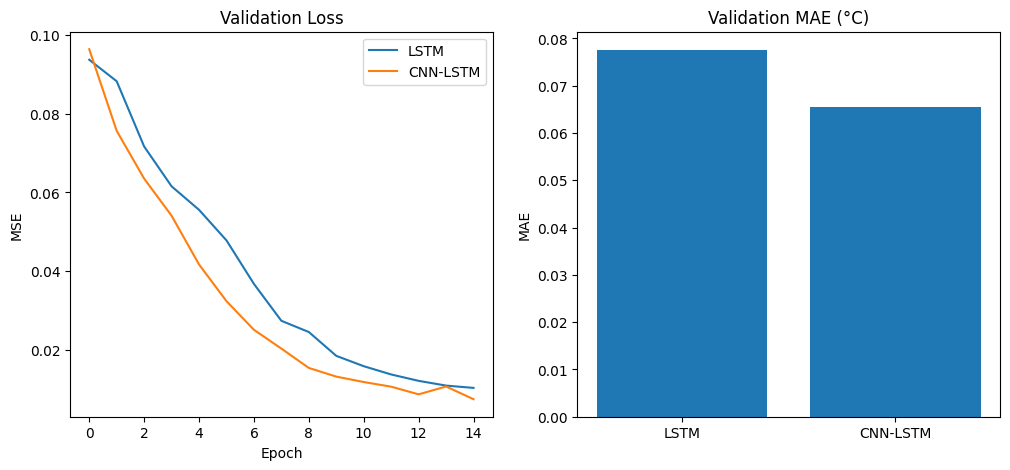

In [8]:
# 计算 MAE（更直观）
def evaluate_mae(model, data_loader):
    device = next(model.parameters()).device
    model.eval()
    total_abs_error = 0
    count = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_abs_error += torch.sum(torch.abs(pred - y)).item()
            count += y.size(0)
    return total_abs_error / count

lstm_mae = evaluate_mae(lstm_model, val_loader)
cnn_lstm_mae = evaluate_mae(cnn_lstm_model, val_loader)

print(f"\nValidation MAE:")
print(f"LSTM:          {lstm_mae:.4f} °C")
print(f"CNN-LSTM:      {cnn_lstm_mae:.4f} °C")

# Plot losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_val_loss, label='LSTM')
plt.plot(cnn_lstm_val_loss, label='CNN-LSTM')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(['LSTM', 'CNN-LSTM'], [lstm_mae, cnn_lstm_mae])
plt.title('Validation MAE (°C)')
plt.ylabel('MAE')
plt.show()